# Generated Data (for testing only)

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from experiment import Experiment
from experiment.datasets import load_cifar10
from sqlalchemy import create_engine
from sqlalchemy.orm import Session

from experiment.models import Configuration, Trial, Result
from datetime import datetime

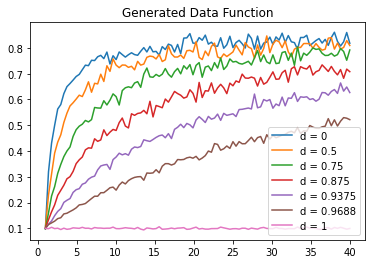

In [2]:
# Test out a function to generate data
def f(x, b, t, d):
    """
    x = batch iteration
    b = baseline accuracy
    t = target accuracy
    d = damping
    """
    y = (b - t) / (d * (1 - x) + x) + t
    noise = y * np.random.normal(0, 0.025)
    return y + noise

# Plot the results
x = np.linspace(1, 40, 100)
for d in [0, 0.5, 0.75, 0.875, 0.9375, 0.9688, 1]:
    y = [f(val, 0.1, 0.85, d) for val in x]
    plt.plot(x, y, label=f'd = {d}')
plt.legend()
plt.title('Generated Data Function');

In [96]:
# Initialize an experiment, but don't run it. Instead, we'll generate the data.
engine = create_engine('sqlite:///../data/generated_data.db')
data = load_cifar10()
experiment = Experiment(engine=engine, model_func=None, data=data)

experiment.initialize_db(overwrite=True)
experiment.configure(
    unc_pct_range=np.linspace(0, 1, 11),
    div_pct_range=[0],
    batch_size=100,
    num_trials=3)

In [97]:
# Generate data
with Session(engine, expire_on_commit=False) as session:
    for config in session.query(Configuration).all():
        for trial_num in range(1, config.num_trials + 1):
            trial = Trial(
                config_id=config.config_id,
                start_time=datetime.utcnow())
            session.add(trial)
            session.commit()
            for batch_num in range(1, 41):
                d = 0.9 * (1 - config.unc_pct)
                acc = f(batch_num, 0.1, 0.85, d)
                result = Result(
                    trial_id=trial.trial_id,
                    batch=batch_num,
                    train_acc = acc,
                    val_acc=acc,
                    test_acc=acc,
                    epochs=np.random.randint(3, 10))
                session.add(result)
            trial.end_time = datetime.utcnow()
            session.add(trial)
    session.commit()

## Explore

In [98]:
sql = '''
SELECT
a.trial_id,
a.batch,
a.test_acc,
a.config_id,
unc_pct
FROM (results
INNER JOIN trials ON results.trial_id = trials.trial_id) as a
INNER JOIN configurations ON a.config_id = configurations.config_id
'''

df = pd.read_sql(sql, engine)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   trial_id   1320 non-null   int64  
 1   batch      1320 non-null   int64  
 2   test_acc   1320 non-null   float64
 3   config_id  1320 non-null   int64  
 4   unc_pct    1320 non-null   float64
dtypes: float64(2), int64(3)
memory usage: 51.7 KB


,trial_id,batch,test_acc,config_id,unc_pct
0,1,1,0.099240,1,0.0
1,1,2,0.168712,1,0.0
2,1,3,0.239297,1,0.0
3,1,4,0.277097,1,0.0
4,1,5,0.319158,1,0.0


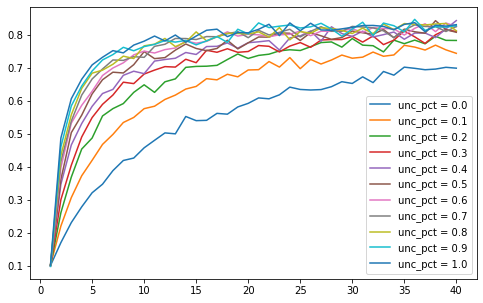

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
grouped = df.groupby(['unc_pct', 'batch'])['test_acc'].mean()
for unc_pct in df['unc_pct'].unique():
    ax.plot(grouped.loc[unc_pct], label=f'unc_pct = {round(unc_pct, 1)}')
ax.legend();